In [12]:
from src.utils import create_kanji_dataset, TrainingConfig
# import torch

dataset = create_kanji_dataset() # hf dataset

#### Model initializing & Upload to HF 
- To be compatible with training script from HF, we need a 'uploaded SD model' on HF.  

In [3]:
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL, PNDMScheduler
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTokenizer
from src.utils import get_transform

# Stable Diffusion 3.5-medium 
# Trying to initialize a randomized-unet + SD3.5 VAE & TextEncoder model and upload to HF, so that training script is directly runnable 
# - I should also consider uploading dataset to HF 

# SD 1.5 model loading

model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"

text_encoder = CLIPTextModel.from_pretrained(
    model_name, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    model_name, subfolder="vae"
)     

noise_scheduler = PNDMScheduler.from_pretrained(
    model_name, 
    subfolder="scheduler"
)

# Load tokenizer (which was missing before)
tokenizer = CLIPTokenizer.from_pretrained(
    model_name, 
    subfolder="tokenizer"
)   
        
# Conditional Denoise Diffusion Model
# unet = UNet2DConditionModel.from_pretrained(
#     model_name, 
#     subfolder="unet"
# )

unet = UNet2DConditionModel(
    sample_size=128,  # probably 64x64 or 128x128 is enough for Kanji
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 256),  # reduced number of channels
    down_block_types=(
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ),
    cross_attention_dim=768,  # Dimension of the text embeddings
)

In [ ]:
from src.utils import evaluate_kanji_pipeline
evaluate_kanji_pipeline(unet, dataset, n_rows=2, n_cols=4, seed=33, out_dir="runs", out_name="kanji_eval.png")

In [5]:
# Debug against minimal training pipeline ... 
from datasets import load_dataset
dataset_name = "lambdalabs/naruto-blip-captions"
dataset = load_dataset(dataset_name)

Repo card metadata block was not found. Setting CardData to empty.


In [1]:
dataset_name = "Ksgk-fy/kanji-dataset"
from datasets import load_dataset
dataset = load_dataset(dataset_name)


In [2]:
from src.utils import augment_dataset
examples = dataset['train'][0]
augmented_examples = augment_dataset(examples)

In [10]:
# Augment Dataset 
from src.utils import augment_dataset
from datasets import load_dataset

dataset = load_dataset("Ksgk-fy/augmented-kanji-dataset")


# expanded_dataset = dataset.map(augment_dataset, num_proc=10)

# expanded_dataset.push_to_hub("Ksgk-fy/augmented-kanji-dataset")

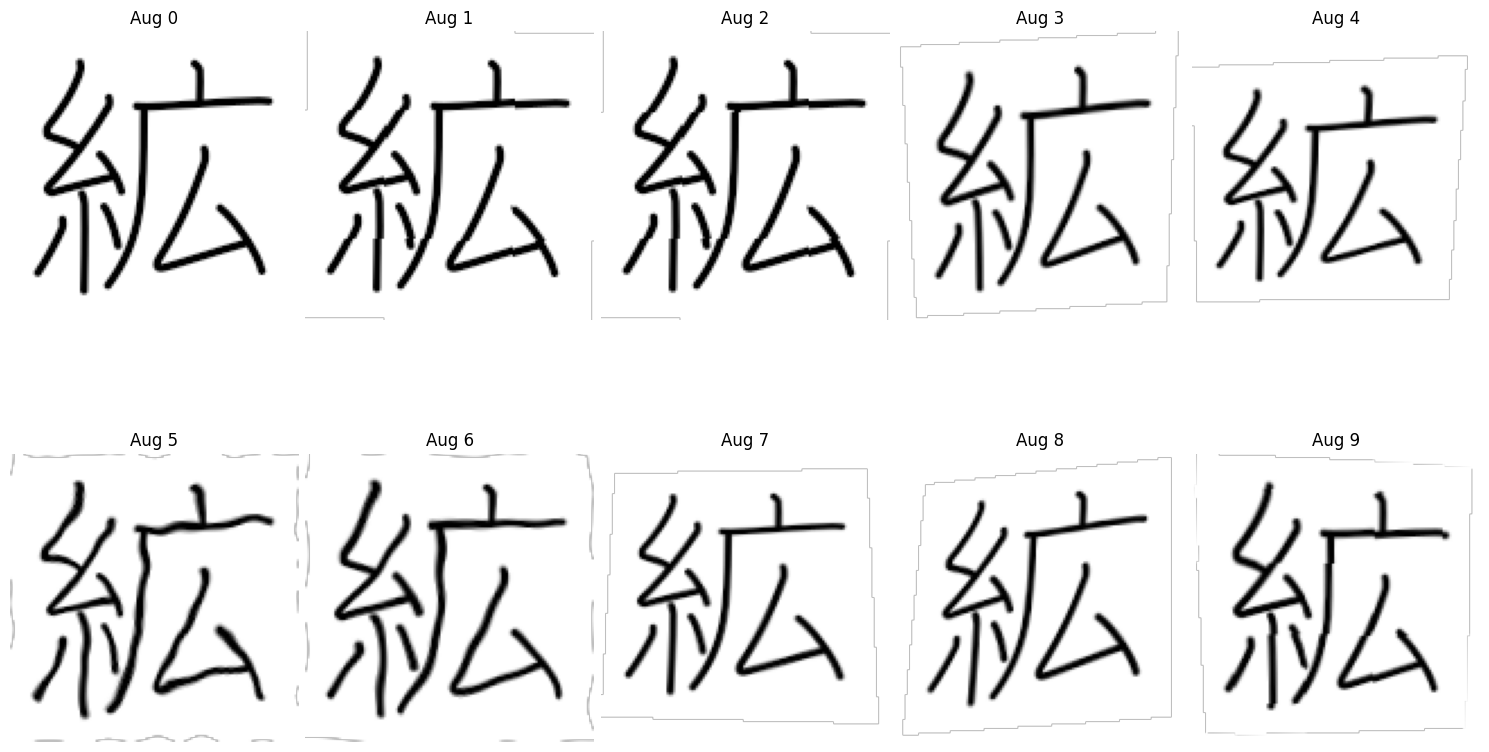

In [7]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each augmented image
n_images = len(augmented_examples['image'])
n_cols = 5  # You can adjust this
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Plot each augmented image
for idx, img in enumerate(augmented_examples['image']):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Aug {idx}')

# Remove empty subplots if any
for idx in range(n_images, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(h_pad=0.1, w_pad=0.5)  # Reduce spacing between subplots
plt.show()

In [7]:
from diffusers import StableDiffusionPipeline

# Create the complete pipeline
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,  # Optional: set to None if you don't need content filtering
    feature_extractor=None,  # Optional: set to None if you don't need feature extraction
    requires_safety_checker=False
)

from src.utils import rgb_to_gray
img = pipeline("girrafe on a plane", num_inference_steps=25).images[0]
gray_img = rgb_to_gray(img)
gray_img # visualize and check gray scale conversion